In [3]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
# import isodata
import os
from tqdm import tqdm

In [4]:
path_home = os.getcwd()
path_data = path_home + '/data/'

In [5]:
caiso = isodata.CAISO()
print('markets:', caiso.markets)
# caiso.get_pnodes()

NameError: name 'isodata' is not defined

In [5]:
# write months of data to temporary location
nodes = ['TH_NP15_GEN-APND']
node_pathname = f'caiso_{nodes[0].lower()}/'
market = 'REAL_TIME_15_MIN'
sleep=5

for y in [2020, 2021, 2022]:
    for m in tqdm(range(1,12+1)):
        # define start/ end dates
        dt_start = f'{m}/1/{y}'
        if m == 12:
            dt_end = f'{1}/1/{y+1}'
        else:
            dt_end = f'{m+1}/1/{y}'

        # pull data
        caiso_month = caiso.get_historical_lmp(date=dt_start, end=dt_end, 
                                               market=market, locations=nodes, 
                                               sleep=sleep, verbose=False)
        
        # save chunk
        # If folder doesn't exist, then create it.
        path_node = f'{path_data}{node_pathname}'
        if not os.path.isdir(path_node):
            os.makedirs(path_node)
            print("created folder: ", path_node)

        caiso_month.to_csv(f'{path_node}{market.lower()}_y{y}m{m}.csv', index=False)


  8%|███▋                                        | 1/12 [00:44<08:08, 44.37s/it]

created folder:  /Users/etriesch/dev/battery-charger/data/caiso_th_np15_gen-apnd/


100%|███████████████████████████████████████████| 12/12 [10:20<00:00, 51.72s/it]


In [6]:
# read in data
nodes = ['TH_NP15_GEN-APND']
node_pathname = f'caiso_{nodes[0].lower()}/'
path_node = f'{path_data}{node_pathname}'
market = 'REAL_TIME_15_MIN'
y=2022
m=12

data = pd.read_csv(f'{path_node}{market.lower()}_y{y}m{m}.csv')
t, d = data.shape

In [109]:
t = 1440

In [110]:
# constants
efficiency = 0.95 # roundtrip efficiency -- energy charged : energy discharged
charge_capacity = 60 # maximum charge/discharge capacity (power capacity)
duration = 100 # storage
energy_capacity = duration*charge_capacity # energy capacity
p = data.LMP.to_numpy()[:t]

In [118]:
def get_battery_schedule(px, duration, charge_capacity=60, efficiency=0.95):
    t = len(px)
    energy_capacity = duration*charge_capacity
    
    # variables
    c = cp.Variable(t) # charging at time t
    e = cp.Variable(t) # energy at time t
    # constraints
    constraints = [e[1:] == e[:t-1] + c[:t-1]] # evolution of energy over time
#     constraints += [e[0] == e[t-1] + c[t-1]] # no carry over night
#     constraints += PLACEHOLDER FOR CYCLE LIMIT
    constraints += [e <= energy_capacity, e >= 0] # energy capacity requirements
    constraints += [c <= charge_capacity, c >= -charge_capacity] # power capacity requirements
    # problem
    obj = cp.Maximize(px @ c)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    
    return e.value, c.value, prob.value
    

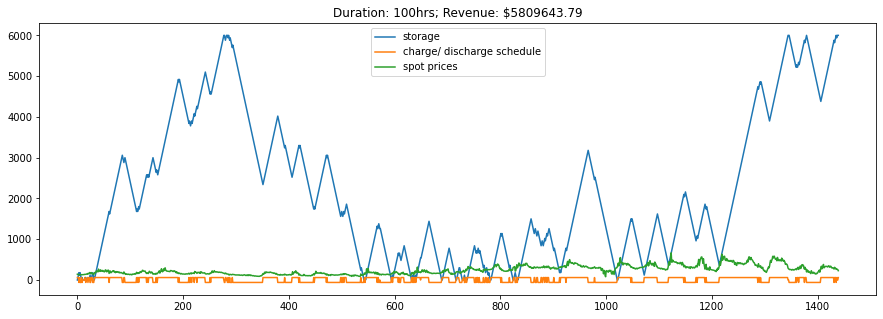

In [119]:
duration = 100
e, c, rev = get_battery_schedule(p[:t], duration=duration, charge_capacity=60, efficiency=0.95)

plt.figure(figsize=(15, 5))
plt.title(f'Duration: {duration}hrs; Revenue: ${rev:0.2f}')
plt.plot(range(t), e, label='storage')
plt.plot(range(t), c, label='charge/ discharge schedule')
plt.plot(range(t), p, label='spot prices')
plt.legend()
plt.show()

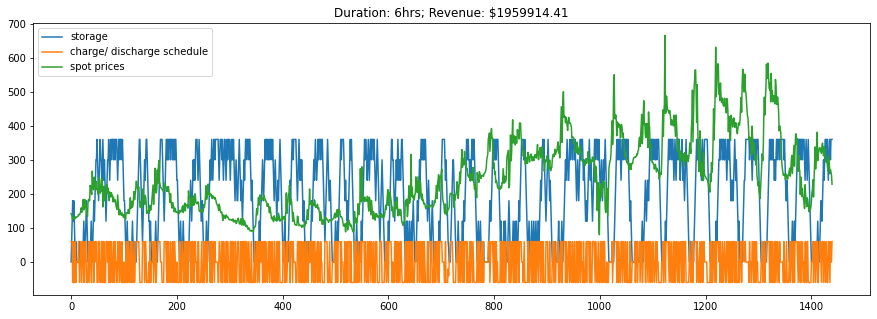

In [120]:
duration = 6
e, c, rev = get_battery_schedule(p[:t], duration=duration, charge_capacity=60, efficiency=0.95)

plt.figure(figsize=(15, 5))
plt.title(f'Duration: {duration}hrs; Revenue: ${rev:0.2f}')
plt.plot(range(t), e, label='storage')
plt.plot(range(t), c, label='charge/ discharge schedule')
plt.plot(range(t), p, label='spot prices')
plt.legend()
plt.show()

In [123]:
cap_step, dur_step = 10, 5
durations = np.arange(1, 100, dur_step)
capacities = np.arange(cap_step, 160, cap_step)
log = np.zeros((len(capacities), len(durations)))
for i, cap in enumerate(capacities):
    for j, dur in enumerate(durations):
        __, __, log[i, j] = get_battery_schedule(p[:t], duration=dur, charge_capacity=cap, efficiency=0.95)
        


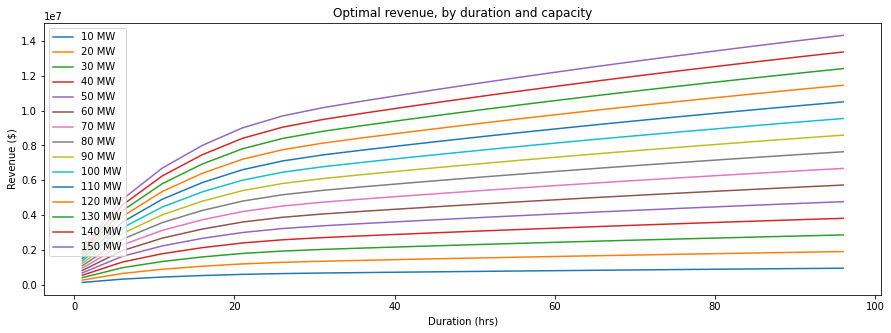

In [124]:
fig = plt.figure(figsize=(15, 5))
for i, cap in enumerate(log):
    plt.plot(durations, cap, label=f'{(i+1)*cap_step} MW')
    
plt.title('Optimal revenue, by duration and capacity')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()